In [1]:
%%capture
! cd $HOME/ICAROS; git checkout master;

In [2]:
! echo $PYTHONPATH

/home/ausonandres/ICAROS_test:/home/ausonandres/IC:/home/ausonandres/ICARO:/data4/NEXT/sw/root/lib:::/data4/NEXT/sw/root/lib


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from  invisible_cities.io.dst_io              import load_dst
from  invisible_cities.core .core_functions   import in_range

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
default_n_bins = 10

_Downloading files from Marija's dropbox:_

In [5]:
%%capture
! wget https://www.dropbox.com/s/025si49skkv6n49/kdst_7517_LB_0-100_TestMapScript.h5
! wget https://www.dropbox.com/s/3ky8js2yekh4sqw/kr_emap_xy_100_100_r_6573_time.h5
! wget https://www.dropbox.com/s/5n9gj9wjcz70na7/z_dst_LB_mean_ref.h5

_Setting files:_

In [6]:
from invisible_cities.core.configure         import configure

run_number = 7517
file_bootstrap   = 'kr_emap_xy_100_100_r_6573_time.h5'
output_maps_file = './'
map_file_out     = os.path.join(output_maps_file, 'map_{0}.h5'.format(run_number)   )
histo_file_out   = os.path.join(output_maps_file, 'histos_{0}.h5'.format(run_number))

folder_dst = './'
dst_file   = 'kdst_7517_LB_0-100_TestMapScript.h5'
input_dst_filenames = folder_dst + dst_file

print('Input dst: ', input_dst_filenames)
print('Output map file: ', map_file_out)
print('Output histograms file: ', histo_file_out)

config_file    = '$ICARO/krcal/map_builder/config_LBphys.conf'

config = configure(f'maps {config_file}'.split())

Input dst:  ./kdst_7517_LB_0-100_TestMapScript.h5
Output map file:  ./map_7517.h5
Output histograms file:  ./histos_7517.h5


_Let's store some parameters from configuration file for map building:_

In [7]:
map_params = config.as_namespace.map_params
nbins_z    = map_params['nbins_z'   ]
nbins_e    = map_params['nbins_e'   ]
z_range    = map_params['z_range'   ]
e_range    = map_params['e_range'   ]
chi2_range = map_params['chi2_range']
lt_range   = map_params['lt_range'  ]
nmin       = map_params['nmin'      ]
r_max      = map_params['r_max'     ]
r_fid      = map_params['r_fid'     ]
x_range    = map_params['x_range'   ]
y_range    = map_params['y_range'   ]

***

# v1.0

__Checkout to v1.0__

In [8]:
#%%capture
! cd $HOME/ICAROS; export GIT_LFS_SKIP_SMUDGE=1; git checkout v1.0; 

Note: checking out 'v1.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b new_branch_name

HEAD is now at 633f217... Merge pull request #24 from ausonandres/add_time_parameters
\nThis repository is configured for Git LFS but 'git-lfs' was not found on your path. If you no longer wish to use Git LFS, remove this hook by deleting .git/hooks/post-checkout.\n


Total number of S2s   : 63176 
Total number of events: 54091
Events after selection: 43404


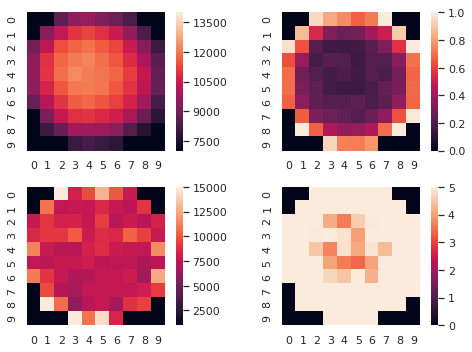

In [9]:
import krcal
from krcal.core.core_functions            import time_delta_from_time
from krcal.core.ranges_and_bins_functions import kr_ranges_and_bins
from krcal.core.analysis_functions        import kr_event
from krcal.core.io_functions              import read_maps
from krcal.core.correction_functions      import e0_xy_correction
from krcal.core.map_functions             import amap_max
from krcal.core.analysis_functions        import selection_in_band
from krcal.core.analysis_functions        import plot_selection_in_band
from krcal.core.selection_functions       import select_xy_sectors_df
from krcal.core.selection_functions       import event_map_df
from krcal.core.fitmap_functions          import fit_map_xy_df
from krcal.core.map_functions             import tsmap_from_fmap
from krcal.core.map_functions             import amap_from_tsmap
from krcal.core.map_functions             import amap_average
from krcal.core.map_functions             import relative_errors
from krcal.core.map_functions             import amap_replace_nan_by_mean
from krcal.core.xy_maps_functions         import draw_xy_maps
from krcal.core.map_functions             import add_mapinfo
from krcal.core.io_functions              import write_maps
from krcal.core.kr_types                  import FitType
from krcal.core.kr_types                  import ASectorMap
import logging
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

dst_full = load_dst(input_dst_filenames, "DST", "Events")
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

## Event Selection
dst1s1 = dst_full[dst_full.nS1==1]
dst    = dst1s1[dst1s1.nS2==1]
dst    = dst[dst.R < 200]

s2e_range = (2000, 18000)
s2q_range = (200, 800)
s1e_range = (3, 25)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = x_range,
                                                        yrange    = y_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = default_n_bins,
                                                        ynbins    = default_n_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 1) # tsamples in seconds


# Bootstrap correction
emaps = read_maps(filename=file_bootstrap)
norm = amap_max(emaps)
E = e0_xy_correction(dst.S2e.values,
                     dst.X.values,
                     dst.Y.values,
                     E0M = emaps.e0 / norm.e0, 
                     xr  = krRanges.X,
                     yr  = krRanges.Y,
                     nx  = 100, 
                     ny  = 100)

range_krs2 = (10e+3,14e+3)
kre = kr_event(dst)
sel_krband, fpl, fph, hp, pp = selection_in_band(kre.Z,
                                                 E,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 50,
                                                 nbins_e = 50,
                                                 nsigma  = 3.5)

dst = dst[sel_krband]
print('Events after selection:', dst.event.nunique())
# Time differences in seconds
dst_time = dst.sort_values('event')
T        = dst_time.time.values
DT       = time_delta_from_time(T)
dst      = dst.assign(DT=DT)

KRES = select_xy_sectors_df(dst, krBins.X, krBins.Y)
neM = event_map_df(KRES)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fpmxy = fit_map_xy_df(selection_map = KRES,
                          event_map     = neM,
                          n_time_bins   = 1,
                          time_diffs    = DT,
                          nbins_z       = krNbins.Z, 
                          nbins_e       = krNbins.S2e, 
                          range_z       = z_range, 
                          range_e       = e_range,
                          energy        = 'S2e',
                          fit           = FitType.unbined,
                          n_min         = 100)

times = fpmxy[0][0].ts
tsm = tsmap_from_fmap(fpmxy)
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = chi2_range,
                     range_lt    = lt_range)

#Get rid of outlayers that distort mean and error
def asm_copy(amap):
    return ASectorMap(chi2  = amap.chi2.copy(),
                      e0    = amap.e0.copy(),
                      lt    = amap.lt.copy(),
                      e0u   = amap.e0u.copy(),
                      ltu   = amap.ltu.copy(),
                      mapinfo   = None)

def regularize_maps_chi2(amap_old, x2range):

    amap = asm_copy(amap_old)
    
    for i in range(len(amap.lt)):
        for j in range(len(amap.lt[i])):
            if amap.chi2[i][j] > x2range[1] or amap.chi2[i][j] < x2range[0]:
                amap.lt[i][j] = np.nan
                amap.ltu[i][j] = np.nan
                amap.e0[i][j] = np.nan
                amap.e0u[i][j] = np.nan

    return amap

regularize = True
if regularize:
    rmap = regularize_maps_chi2(am, x2range = (0, 2))
    amap_average(rmap)
    asm = relative_errors(rmap)
else:
    asm = relative_errors(am)

amv = amap_average(asm)
#asmAv = amap_replace_nan_by_mean(asm, amMean=amv)
draw_xy_maps(asm,
            e0lims  = (7000, 14000),
            ltlims  = (1000, 15000),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(7,5))
asm = add_mapinfo(asm, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)
asm_v1 = asm
#write_maps(asm, filename=emap_file_name)

****

# v2.0

__Checkout to v2.0__

In [10]:
#%%capture
! cd $HOME/ICAROS; export GIT_LFS_SKIP_SMUDGE=1; git checkout v2.0;

Previous HEAD position was 633f217... Merge pull request #24 from ausonandres/add_time_parameters
HEAD is now at 2647521... 26 Krcalib2.0
\nThis repository is configured for Git LFS but 'git-lfs' was not found on your path. If you no longer wish to use Git LFS, remove this hook by deleting .git/hooks/post-checkout.\n


Total number of S2s   : 63176 
Total number of events: 54091
Events after selection: 43404
 set nans to average value of interval = 100025.0
 set nans to average value of interval = 50250.0


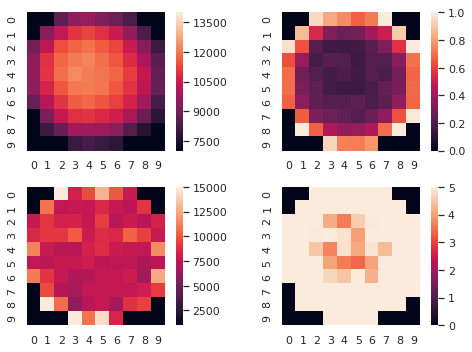

In [11]:
import krcal
from krcal.core.ranges_and_bins_functions     import kr_ranges_and_bins
from krcal.core.core_functions                import time_delta_from_time
from krcal.core.histo_functions               import h2d, h2
from krcal.core.kr_types                      import PlotLabels
from krcal.core.io_functions                  import read_maps
from krcal.core.map_functions                 import amap_max
from krcal.core.xy_maps_functions             import draw_xy_maps
from krcal.core.core_functions                import timeit
from krcal.core.correction_functions          import e0_xy_correction
from krcal.core.selection_functions           import selection_in_band
from krcal.core.selection_functions           import plot_selection_in_band
from krcal.core.selection_functions           import selection_info
from krcal.core.selection_functions           import select_xy_sectors_df
from krcal.core.selection_functions           import event_map_df
from krcal.core.fitmap_functions              import fit_map_xy_df
from krcal.core.map_functions                 import tsmap_from_fmap
from krcal.core.map_functions                 import amap_from_tsmap
from krcal.core.map_functions                 import regularize_maps
from krcal.core.map_functions                 import relative_errors
from krcal.core.map_functions                 import amap_average
from krcal.core.map_functions                 import amap_replace_nan_by_mean
from krcal.core.kr_types                      import FitType
from krcal.core.map_functions                 import add_mapinfo


import logging
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

dst_full = load_dst(input_dst_filenames, "DST", "Events")
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

dst_f  = dst_full[in_range(dst_full.R, 0, 200) ]
dst1s1 = dst_f[in_range(dst_f.nS1, 1,2)]
dst    = dst1s1[in_range(dst1s1.nS2, 1, 2)]
dst    = dst [in_range(dst.X, -200, 200)]
dst    = dst [in_range(dst.Y, -200, 200)]


RMAX      = 200
s1e_range = (3, 25)
s2e_range = (2000, 18000)
s2q_range = (200, 800)


krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = x_range,
                                                        yrange    = y_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = default_n_bins,
                                                        ynbins    = default_n_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 1) # tsamples in seconds

dstx     = dst[in_range(dst.X, -RMAX, RMAX)]
dst      = dstx[in_range(dstx.Y, -RMAX, RMAX)]

bootstrap_corr_f   = file_bootstrap
write_filtered_dst = False
emaps = read_maps(filename=bootstrap_corr_f)
norm = amap_max(emaps)

E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = 100, 
                      ny  = 100)

range_krs2 = (10.0e+3,14e+3)
sel_krband, fpl, fph, hp, pp = selection_in_band(dst.Z, E0,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 50,
                                                 nbins_e = 50,
                                                 nsigma  = 3.5)
dst  = dst.assign(E0=E0)
dsts = dst[sel_krband]

dst_time = dsts.sort_values('time')
T        = dst_time.time.values
DT       = time_delta_from_time(T)
dsts     = dsts.assign(DT=DT)


print('Events after selection:', dsts.event.nunique())

# Map creation
KXY = select_xy_sectors_df(dsts, krBins.X, krBins.Y)
nXY = event_map_df(KXY)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = fit_map_xy_df(selection_map = KXY,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 100)

tsm = tsmap_from_fmap(fmxy)
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = chi2_range,
                     range_lt    = lt_range)

rmap = regularize_maps(am, erange=(50,200000), ltrange=(500,100000))
asm = relative_errors(rmap)
#amv = amap_average(asm)
#asmAv = amap_replace_nan_by_mean(asm, amMean=amv)
asm = add_mapinfo(asm, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=7517)

asm_v2 = asm
draw_xy_maps(asm_v2,
            e0lims  = (7000, 14000),
            ltlims  = (1000, 15000),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize = (7,5))

***

# clean_krcalib

__Checkout to mmkekic/clean_krcalib branch__

In [12]:
%%capture
! cd $HOME/ICAROS; export GIT_LFS_SKIP_SMUDGE=1; git remote add mmkekic https://github.com/mmkekic/ICAROS.git; git fetch mmkekic; git checkout mmkekic/clean_krcalib;

In [13]:
import krcal
from krcal.map_builder.map_builder_functions import map_builder
from invisible_cities.reco.corrections_new   import read_maps
from krcal.NB_utils   .xy_maps_functions     import draw_xy_maps
import logging
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

ref_histo_file = 'z_dst_LB_mean_ref.h5'
config = configure('maps $ICARO/krcal/map_builder/config_LBphys.conf'.split())
print(folder_dst + dst_file)
run_number     = 7517
config.update(dict(run_number         = run_number,
                   folder             = folder_dst   ,
                   file_in            = dst_file,
                   file_out_map       = map_file_out,
                   file_out_hists     = histo_file_out,
                   default_n_bins     = default_n_bins,
                   file_bootstrap_map = file_bootstrap,
                   ref_Z_histogram    = dict(
                   ref_histo_file     = ref_histo_file,
                   key_Z_histo        = 'histo_Z_dst')))
map_builder(config.as_namespace)
map_3 = read_maps(map_file_out)
draw_xy_maps(map_3,
             e0lims  = (7000, 14000),
             ltlims  = (1000, 15000),
             eulims  = (0.0,  1),
             lulims  = (0, 5),
             figsize = (7,5))

./kdst_7517_LB_0-100_TestMapScript.h5
Map builder starting...
Reading input files:
    Input dst folder   : ./
    Input boostrap map : kr_emap_xy_100_100_r_6573_time.h5
    Input histogram map: z_dst_LB_mean_ref.h5
Checking the dst and appling 1S1, 1S2 and z-band selections:
    Number of events before any selection: 52879
    1 S1 cut efficiency within the expectations (89.08%)
    1 S2 cut efficiency within the expectations (98.24%)
    Z band cut efficiency within the expectations (93.80%)
    Number of events passing the cuts: 43404 (82.08%)
Map computation:
    Number of bins: 10x10
    Number of failing fits: 0
    Mean core E0: 12359.5+-nan pes
    Mean core Lt: 7905.9+-nan mus
Map successfully computed and saved in : ./map_7517.h5
Control histograms saved in            : ./histos_7517.h5


***

***

# Map comparison

## v1.0 & v2.0

In [15]:
from invisible_cities.core.testing_utils   import assert_dataframes_close

In [16]:
assert_dataframes_close(asm_v1.e0 , asm_v2.e0 , rtol=1e-5 )
assert_dataframes_close(asm_v1.e0u, asm_v2.e0u, rtol=1e-5)
assert_dataframes_close(asm_v1.lt , asm_v2.lt , rtol=1e-5 )
assert_dataframes_close(asm_v1.ltu, asm_v2.ltu, rtol=1e-5)

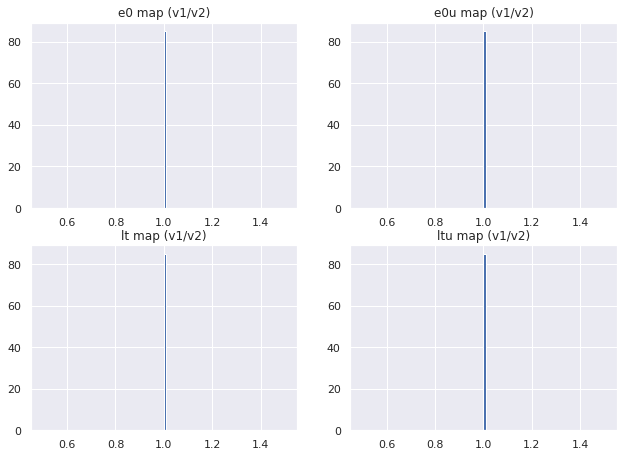

In [17]:
plt.figure(figsize=(10.5,7.5));
e0_v1 = asm_v1.e0.values
e0_v2 = asm_v2.e0.values
plt.subplot(2,2,1);
plt.hist(e0_v1.flatten()/e0_v2.flatten(), 100);
plt.title('e0 map (v1/v2)');

plt.subplot(2,2,2);
e0u_v1 = asm_v1.e0u.values
e0u_v2 = asm_v2.e0u.values
plt.hist(e0u_v1.flatten()/e0u_v2.flatten(), 100);
plt.title('e0u map (v1/v2)');

plt.subplot(2,2,3);
lt_v1 = asm_v1.lt.values
lt_v2 = asm_v2.lt.values
plt.hist(lt_v1.flatten()/lt_v2.flatten(), 100);
plt.title('lt map (v1/v2)');

plt.subplot(2,2,4);
ltu_v1 = asm_v1.ltu.values
ltu_v2 = asm_v2.ltu.values
plt.hist(ltu_v1.flatten()/ltu_v2.flatten(), 100);
plt.title('ltu map (v1/v2)');

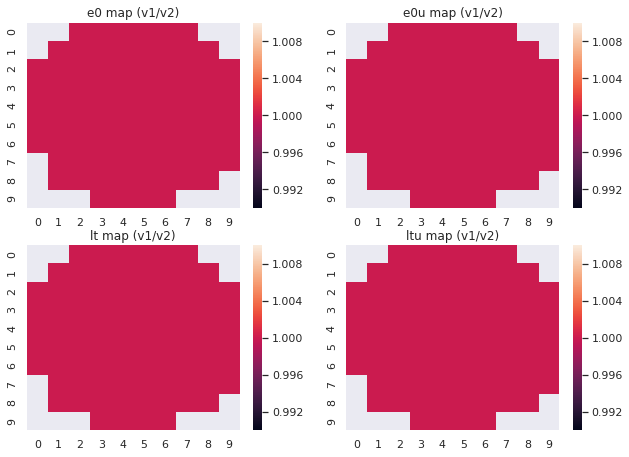

In [18]:
plt.figure(figsize=(10.5,7.5));
plt.subplot(2,2,1);
sns.heatmap(e0_v1/e0_v2, vmin=0.99, vmax=1.01);
plt.title('e0 map (v1/v2)');

plt.subplot(2,2,2);
sns.heatmap(e0u_v1/e0u_v2, vmin=0.99, vmax=1.01);
plt.title('e0u map (v1/v2)');

plt.subplot(2,2,3);
sns.heatmap(lt_v1/lt_v2, vmin=0.99, vmax=1.01);
plt.title('lt map (v1/v2)');

plt.subplot(2,2,4);
sns.heatmap(ltu_v1/ltu_v2, vmin=0.99, vmax=1.01);
plt.title('ltu map (v1/v2)');

## v1.0 & v2.0 & mmkekic/clean_krcalib

In [19]:
from krcal.map_builder.checking_functions import get_core

In [20]:
mask_core = get_core(default_n_bins, 200, 200)

In [21]:
map_v1 = asm_copy(asm_v1)
map_v2 = asm_copy(asm_v2)

In [22]:
map_v1.e0  = map_v1.e0.where(mask_core)
map_v1.e0u = map_v1.e0u.where(mask_core)
map_v1.lt  = map_v1.lt.where(mask_core)
map_v1.ltu = map_v1.ltu.where(mask_core)

map_v2.e0  = map_v2.e0.where(mask_core)
map_v2.e0u = map_v2.e0u.where(mask_core)
map_v2.lt  = map_v2.lt.where(mask_core)
map_v2.ltu = map_v2.ltu.where(mask_core)

In [23]:
map_new = read_maps(map_file_out)

In [24]:
assert_dataframes_close(map_v1.e0 , map_new.e0 , rtol=1e-5)
assert_dataframes_close(map_v1.e0u, map_new.e0u, rtol=1e-5)
assert_dataframes_close(map_v1.lt , map_new.lt , rtol=1e-5)
assert_dataframes_close(map_v1.ltu, map_new.ltu, rtol=1e-5)

assert_dataframes_close(map_v2.e0 , map_new.e0 , rtol=1e-5)
assert_dataframes_close(map_v2.e0u, map_new.e0u, rtol=1e-5)
assert_dataframes_close(map_v2.lt , map_new.lt , rtol=1e-5)
assert_dataframes_close(map_v2.ltu, map_new.ltu, rtol=1e-5)